# Statistical analysis of the WUIX results

* Import the village parametres and define the ones to compare.
* Merge the WUIX results with the building polygons (the highest WUIX in contact with the building is attributed to it).
* Join villages and prepare visuals of the distribution of the data individually or grouped in ranges.
* Test the normality of the data and apply statistical methods to assess the differences between the types of affectation.

### Import village parametres

In [178]:
import json

village_comp_all = ['Sarzedas de Vasco', 'Sarzedas de Sao Pedro', 'Figueira'] # Data available only for these ones

with open('./village_info.json') as file:
    village = json.load(file)

village

{'name': 'Figueira',
 'year': '2015',
 'n_number': '30',
 'size_Rf': 1,
 'srs': 'EPSG:4326',
 'size': [1500, 1500],
 'nodata_value': '0',
 'bounds': {'minx': -8.238677953804158,
  'miny': 39.915521016487965,
  'maxx': -8.225188129621907,
  'maxy': 39.929010840576744}}

In [185]:
from math import trunc


big_cell = trunc(float(village["n_number"])) * village["size_Rf"]

outputs = ['CONT', 'FRIC', 'URBA', 'WUIX']
out_type = ['UNIT', 'NORM', 'SPEC', 'TOTAL']

wuix2_input = ['house', 'veget']
wuix2_output = []
wuix2_output_higher = [f'Tipos_IUF_{big_cell}']

for i in outputs:
    wuix2_output.append(f'{i}_{out_type[0]}_{village["size_Rf"]}')

for i in outputs:
    for j in out_type:
        if j != out_type[0]:
            wuix2_output_higher.append(f'{i}_{j}_{village["size_Rf"]}_{big_cell}')

## Merge the WUIX results with the building polygons 
* The highest WUIX in contact with the building is attributed to it.

In [245]:
import os
import numpy as np
import pandas as pd

import rasterio
from rasterio.transform import from_origin


def asc_to_raster(input_file, output_file):
    ''' 
    Get an ASCII file (text file), convert to a raster .tif and saves the file.
    - Use the information from the heading of the ASCII file for georeferencing the image raster. 
    ''' 
    # Read the heading of ASCII file to define parameters of conversion
    with open(input_file, 'r') as file:
        ncols = int(file.readline().split()[1])
        nrows = int(file.readline().split()[1])
        xllcorner = float(file.readline().split()[1])
        yllcorner = float(file.readline().split()[1])
        cellsize = float(file.readline().split()[1])

    # Read ASCII data skipping the heading rows
    data = np.loadtxt(input_file, skiprows=6, dtype=str)
    data = np.char.replace(data.astype(str), ',', '.')
    data = np.char.replace(data.astype(str), '"', '')
    data = data.astype(float)

    # Define transformation parameters
    west = xllcorner
    north = yllcorner + (nrows * cellsize)
    transform = from_origin(west, north, cellsize, cellsize)

    # Create and save raster file
    with rasterio.open(output_file, 'w', driver='GTiff', height=data.shape[0], width=data.shape[1],
                       count=1, dtype=data.dtype, crs=village["srs"], transform=transform) as dst:
        dst.write(data, 1)

# Path for files ASCII and output files
input_path = f'../data/outputs/{village["name"]}/{village["year"]}/resolution_{village["size_Rf"]}/'
output_path = f'{input_path}data_tif/'

if not os.path.exists(output_path):
    os.mkdir(output_path)

# Apply the conversion for each output separately
for file in wuix2_output_higher:
    if not file == f'Tipos_IUF_{village["n_number"]}':
        
        asc_to_raster(input_path + file + '.asc', output_path + file + '.tif')
        print(file)

CONT_NORM_1_30
CONT_SPEC_1_30
CONT_TOTAL_1_30
FRIC_NORM_1_30
FRIC_SPEC_1_30
FRIC_TOTAL_1_30
URBA_NORM_1_30
URBA_SPEC_1_30
URBA_TOTAL_1_30
WUIX_NORM_1_30
WUIX_SPEC_1_30
WUIX_TOTAL_1_30


In [246]:
import fiona
import geopandas as gpd
from rasterio.features import shapes

def raster_to_shapefile(raster_file, shapefile, file):
    ''' 
    Get a raster file (image), convert to a shapefile (.shp) and saves the file.
    ''' 
    with rasterio.open(raster_file) as src:
        
        data = src.read(1).astype('float32')

        # Generate shapes from raster
        results = ({'geometry': s, 'properties': {f'{file}': v}} for i, (s, v) in
                   enumerate(shapes(data, mask=None, transform=src.transform)))

        # Write to shapefile
        with fiona.open(shapefile, 'w', driver='ESRI Shapefile', srs=src.crs, schema={'geometry': 'Polygon', 
                                                                                      'properties': {f'{file}': 'float'}}) as dst:
            dst.writerecords(results)

# Path for files raster and output files
raster_path = output_path
shape_path = f'{input_path}shape/'
if not os.path.exists(shape_path):
    os.mkdir(shape_path)

# Apply the conversion for each output separately
for file in wuix2_output_higher:
    if not file == f'Tipos_IUF_{village["n_number"]}':
        raster_to_shapefile(raster_path + file + '.tif', shape_path + file + '.shp', file)
        
        # Delete used raster files
        os.remove(raster_path + file + '.tif')

In [ ]:
# Open the base building polygons in a GeoDataFrame
base_buildings = gpd.read_file(f'../data/shape_files/{village["name"]}/buildings/{village["name"]}.shp')

result_gdf = gpd.GeoDataFrame()

for file in os.listdir(shape_path):
    if file.endswith(f'{village["size_Rf"]}_{village["n_number"]}.shp'):
        if file != f'result_intersection_{village["size_Rf"]}_{village["n_number"]}.shp':
            # Read the shapefile and define SRS
            raster_gdf = gpd.read_file(os.path.join(shape_path, file))
            raster_gdf.crs = village["srs"]

            intersection_gdf = gpd.overlay(base_buildings, raster_gdf, how='intersection')

            # Append the results to the GeoDataFrame
            result_gdf = pd.concat([result_gdf, intersection_gdf], ignore_index=True)              
            # Delete used individual shapefiles
            os.remove(shape_path + file)

for file in os.listdir(shape_path):
    if not 'result_intersection_' in file:
        # Delete other auxiliar files
        os.remove(shape_path + file)

# Save the result GeoDataFrame to a new shapefile
result_shapefile_path = shape_path + f'/result_intersection_{village["size_Rf"]}_{village["n_number"]}.shp'
result_gdf.to_file(result_shapefile_path)
print("The shapefile containing the merged results of the building polygons is in:\n",
      os.path.abspath(result_shapefile_path))

In [249]:
result_gdf.head()

,id,fire_affec,CONT_NORM_,geometry,CONT_SPEC_,CONT_TOTAL,FRIC_NORM_,FRIC_SPEC_,FRIC_TOTAL,URBA_NORM_,URBA_SPEC_,URBA_TOTAL,WUIX_NORM_,WUIX_SPEC_,WUIX_TOTAL
0,1,build_affec,3.0,"POLYGON ((-8.23400 39.92470, -8.23398 39.92469...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,surro_affec,3.0,"POLYGON ((-8.23405 39.92479, -8.23409 39.92475...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,surro_affec,3.0,"POLYGON ((-8.23397 39.92480, -8.23393 39.92478...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,build_affec,37.0,"POLYGON ((-8.23401 39.92469, -8.23398 39.92469...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24,build_affec,37.0,"POLYGON ((-8.23408 39.92442, -8.23409 39.92442...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [250]:
def org_gdf_shapefile(gdf):
    grouped_df = gdf.drop(columns='geometry')
    grouped_df = grouped_df.groupby('id').max()
    if 'type' in grouped_df.columns:
        grouped_df.drop(columns=['type'], inplace=True)
    grouped_df = grouped_df.reset_index()
    return grouped_df

grouped_df = org_gdf_shapefile(result_gdf)
grouped_df

,id,fire_affec,CONT_NORM_,CONT_SPEC_,CONT_TOTAL,FRIC_NORM_,FRIC_SPEC_,FRIC_TOTAL,URBA_NORM_,URBA_SPEC_,URBA_TOTAL,WUIX_NORM_,WUIX_SPEC_,WUIX_TOTAL
0,1,build_affec,37.0,2.209444,1989.0,0.0,0.00,2.0,6.0,0.338333,305.0,0.03,0.0049,3977.0
1,2,surro_affec,8.0,0.453888,409.0,0.0,0.00,0.0,13.0,0.797777,718.0,0.00,0.0000,0.0
2,3,surro_affec,3.0,0.193333,174.0,0.0,0.00,0.0,6.0,0.338333,305.0,0.00,0.0000,0.0
3,4,no_affec,38.0,2.263889,2038.0,0.0,0.01,9.0,23.0,1.371111,1234.0,0.15,0.0226,18338.0
4,5,surro_affec,85.0,5.083889,4576.0,3.0,0.09,77.5,29.0,1.716111,1545.0,2.24,0.3361,272242.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,177,build_affec,34.0,2.010000,1809.0,2.0,0.05,44.0,46.0,2.737778,2464.0,0.51,0.0765,61996.0
177,178,build_affec,5.0,0.283888,256.0,1.0,0.03,24.5,46.0,2.737778,2464.0,0.05,0.0077,6260.0
178,179,build_affec,12.0,0.744444,670.0,2.0,0.06,51.0,32.0,1.935556,1742.0,0.28,0.0422,34170.0
179,180,surro_affec,18.0,1.102778,993.0,1.0,0.02,14.5,28.0,1.685556,1517.0,0.05,0.0076,6192.0


## Join villages and prepare visuals
* Distribution of the data individually or grouped in ranges.

In [253]:
def import_village(village_comp):
    global concat_village
    village_comp_path = rf"..\data\outputs\{village_comp}\{village['year']}\resolution_{village['size_Rf']}\shape\result_intersection_{village['size_Rf']}_{village['n_number']}.shp"
    gdf_comp_village = gpd.read_file(village_comp_path)
    grouped_gdf_comp_village = org_gdf_shapefile(gdf_comp_village)
    grouped_gdf_comp_village['village'] = village_comp
    concat_village = pd.concat([concat_village, grouped_gdf_comp_village])

In [254]:
concat_village = gpd.GeoDataFrame()

grouped_df['village'] = village['name']
concat_village = pd.concat([concat_village, grouped_df])

for item in village_comp_all:
    if item == village['name']:
        None
    else:
        import_village(item)

concat_village

,id,fire_affec,CONT_NORM_,CONT_SPEC_,CONT_TOTAL,FRIC_NORM_,FRIC_SPEC_,FRIC_TOTAL,URBA_NORM_,URBA_SPEC_,URBA_TOTAL,WUIX_NORM_,WUIX_SPEC_,WUIX_TOTAL,village
0,1,build_affec,37.0,2.209444,1989.0,0.0,0.00,2.0,6.0,0.338333,305.0,0.03,0.0049,3977.0,Figueira
1,2,surro_affec,8.0,0.453888,409.0,0.0,0.00,0.0,13.0,0.797777,718.0,0.00,0.0000,0.0,Figueira
2,3,surro_affec,3.0,0.193333,174.0,0.0,0.00,0.0,6.0,0.338333,305.0,0.00,0.0000,0.0,Figueira
3,4,no_affec,38.0,2.263889,2038.0,0.0,0.01,9.0,23.0,1.371111,1234.0,0.15,0.0226,18338.0,Figueira
4,5,surro_affec,85.0,5.083889,4576.0,3.0,0.09,77.5,29.0,1.716111,1545.0,2.24,0.3361,272242.0,Figueira
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,242,surro_affec,14.0,0.836111,753.0,1.0,0.03,26.0,27.0,1.595000,1436.0,0.16,0.0242,19565.0,Sarzedas de Sao Pedro
240,243,surro_affec,62.0,3.741111,3367.0,1.0,0.02,17.0,58.0,3.501667,3152.0,0.47,0.0707,57239.0,Sarzedas de Sao Pedro
241,244,surro_affec,99.0,5.928333,5336.0,0.0,0.01,6.0,71.0,4.258333,3833.0,0.24,0.0362,29345.0,Sarzedas de Sao Pedro
242,245,surro_affec,28.0,1.702778,1533.0,4.0,0.10,91.5,100.0,6.000000,5400.0,0.76,0.1137,92095.0,Sarzedas de Sao Pedro


In [255]:
# Choice for the type of WUIX to adopt in the comparison

type_wuix = 'WUIX_NORM_'
concat_village_shortened = concat_village[['id', 'fire_affec', type_wuix, 'village']]
max_value = concat_village_shortened[type_wuix].max()
n_of_intervals = 8 # number of intervals to calculate the ranges

### Preparation of distribution range by quatile

In [256]:
n_quantiles = n_of_intervals
affec_quantil_perc = []

# Determine quantity of values per quantil
n_items_quantil = concat_village_shortened[type_wuix].count() // n_quantiles

# Sort values for assigning per order in each quantil
sorted_df = concat_village_shortened.copy()
sorted_df = sorted_df.sort_values(by=type_wuix).reset_index(drop=True)

# Calculate percentage of affec/no_affec per quantil
for i in range(n_quantiles):
    min_index_quantil = i * n_items_quantil
    max_index_quantil = (i + 1) * n_items_quantil if i + 1 < n_quantiles else sorted_df[type_wuix].count() - 1

    df_quantil = sorted_df.iloc[min_index_quantil : max_index_quantil]

    no_affec = (df_quantil['fire_affec'] == 'no_affec').sum()
    #surro_affe = (df_quantil['fire_affec'] == 'surro_affec').sum()
    affec = (df_quantil['fire_affec'] != 'no_affec').sum()

    affec_quantil_perc.append({'range': f'{sorted_df.iloc[min_index_quantil, 2].astype("float16"):.2f} - {sorted_df.iloc[max_index_quantil, 2].astype("float16"):.2f}',
                             'no_affec': f'{no_affec / (max_index_quantil - min_index_quantil).sum() * 100:.2f}' if no_affec !=0 else '0.00',
                             #'surro_affec': f'{surro_affe / (max_index_quantil - min_index_quantil).sum() * 100:.2f}' if surro_affe !=0 else '0.00',
                             'build_affec': f'{affec / (max_index_quantil - min_index_quantil).sum() * 100:.2f}' if affec !=0 else '0.00'})
    
affec_quantil_perc = pd.DataFrame(affec_quantil_perc)
affec_quantil_perc.replace([np.inf, -np.inf], np.nan, inplace=True)
affec_quantil_perc

,range,no_affec,build_affec
0,0.00 - 0.04,30.77,69.23
1,0.04 - 0.17,40.00,60.00
2,0.17 - 0.32,21.54,78.46
3,0.32 - 0.51,29.23,70.77
4,0.51 - 0.82,21.54,78.46
5,0.82 - 1.22,30.77,69.23
6,1.22 - 1.81,41.54,58.46
7,1.81 - 5.17,32.31,67.69


### Preparation of distribution range by same number of elements

In [257]:
n_range_values = n_of_intervals
affec_range_perc = []

for i in range(n_range_values):
    min_range_value = i * max_value / n_range_values
    max_range_value = (i + 1) * max_value / n_range_values
    
    range_values = concat_village_shortened[(concat_village_shortened[type_wuix] >= min_range_value) & (concat_village_shortened[type_wuix] < max_range_value)]
    if i == n_range_values - 1:
        range_values = pd.concat([range_values, concat_village_shortened[(concat_village_shortened[type_wuix] == max_range_value)]])
    
    no_affec = (range_values['fire_affec'] == 'no_affec').sum()
    #surro_affe = (range_values['fire_affec'] == 'surro_affec').sum()
    affec = (range_values['fire_affec'] != 'no_affec').sum()
    
    affec_range_perc.append({'range': f'{min_range_value.astype("float16"):.2f} - {max_range_value.astype("float16"):.2f}',
                             'no_affec': f'{no_affec / range_values["fire_affec"].count() * 100:.2f}' if no_affec !=0 else '0.00',
                             #'surro_affec': f'{surro_affe / range_values["fire_affec"].count() * 100:.2f}' if surro_affe !=0 else '0.00',
                             'build_affec': f'{affec / range_values["fire_affec"].count() * 100:.2f}' if affec !=0 else '0.00'})

affec_range_perc = pd.DataFrame(affec_range_perc)
affec_range_perc.replace([np.inf, -np.inf], np.nan, inplace=True)
affec_range_perc

,range,no_affec,build_affec
0,0.00 - 0.65,28.72,71.28
1,0.65 - 1.29,30.77,69.23
2,1.29 - 1.94,40.74,59.26
3,1.94 - 2.59,44.00,56.00
4,2.59 - 3.23,20.83,79.17
5,3.23 - 3.88,0.00,100.00
6,3.88 - 4.52,50.00,50.00
7,4.52 - 5.17,0.00,100.00


### Preparation of individual distribution

In [258]:
affec_by_village = concat_village_shortened.copy()
affec_by_village['fire_affec'] = ['affec' if x != 'no_affec' else 'no_affec' for x in affec_by_village['fire_affec']]

print(f"Buildings affected: {affec_by_village['fire_affec'].value_counts()['affec']} / "
      f"Buildings non affected: {affec_by_village['fire_affec'].value_counts()['no_affec']}")
affec_by_village.reset_index(drop=True, inplace=True)
affec_by_village

Buildings affected: 360 / Buildings non affected: 161


,id,fire_affec,WUIX_NORM_,village
0,1,affec,0.03,Figueira
1,2,affec,0.00,Figueira
2,3,affec,0.00,Figueira
3,4,no_affec,0.15,Figueira
4,5,affec,2.24,Figueira
...,...,...,...,...
516,242,affec,0.16,Sarzedas de Sao Pedro
517,243,affec,0.47,Sarzedas de Sao Pedro
518,244,affec,0.24,Sarzedas de Sao Pedro
519,245,affec,0.76,Sarzedas de Sao Pedro


### Plots of distribution

In [259]:
def split_string_at_middle(entire_string):

    middle_index = len(entire_string) // 2
    space_index = entire_string.find(' ', middle_index)

    first_part = entire_string[:space_index]
    second_part = entire_string[space_index:].lstrip()
    if space_index == -1:
        return entire_string

    return f"{first_part}\n{second_part}"

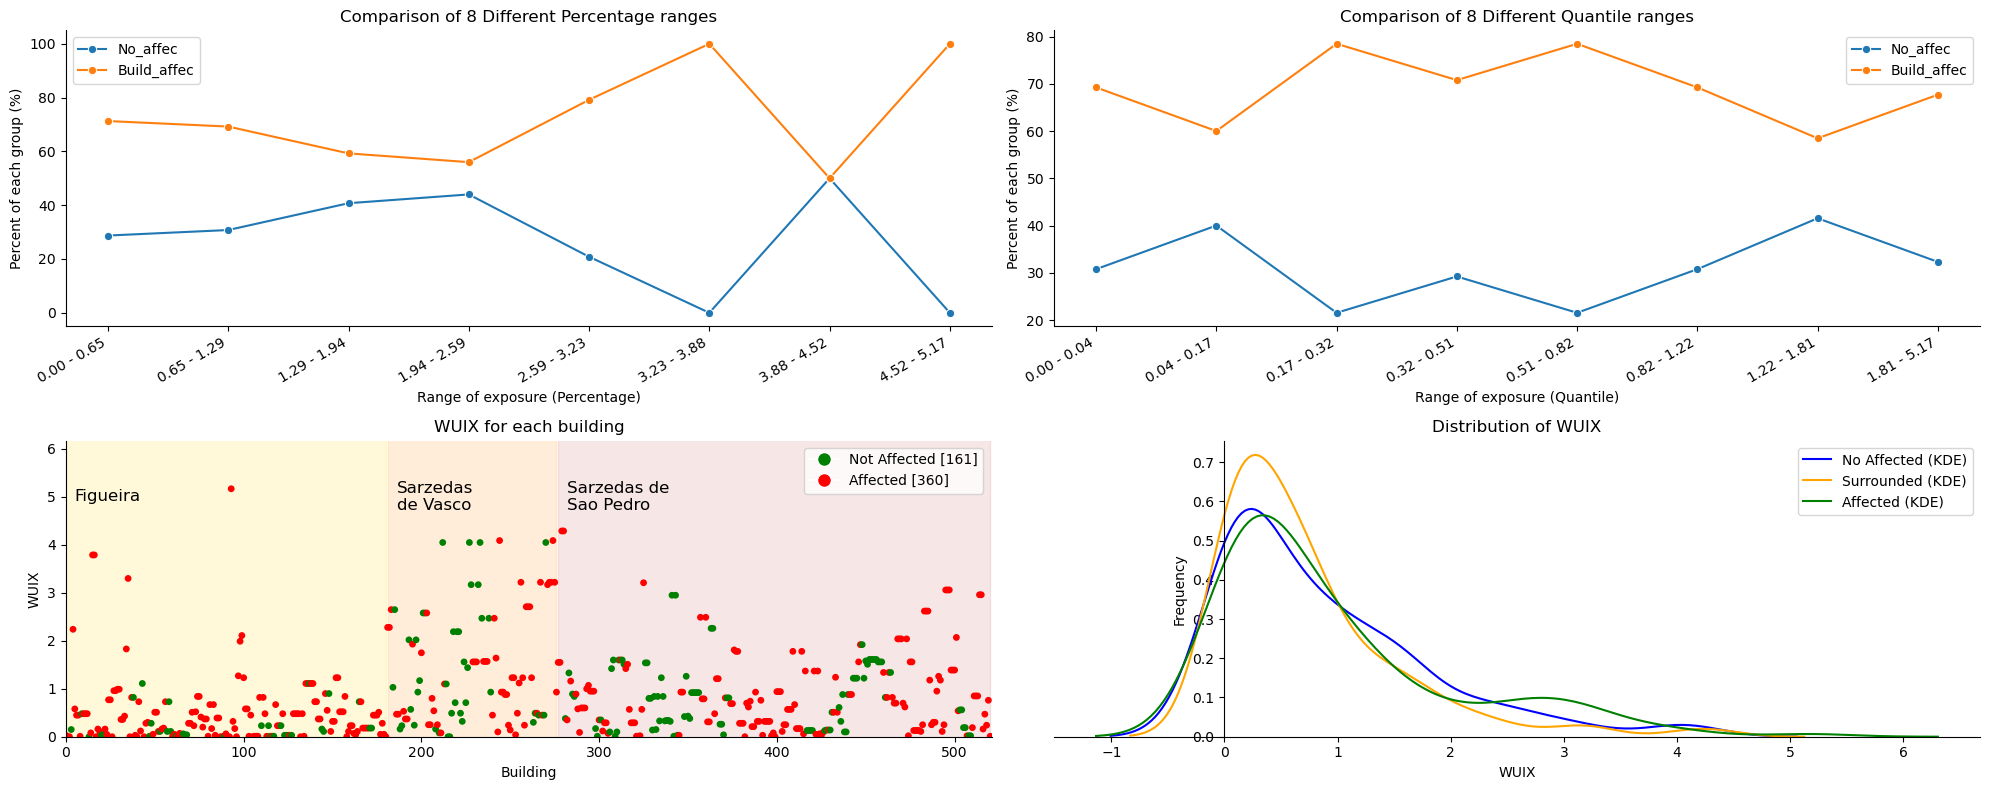

In [260]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def plot_box():
    ax[row, col].spines['right'].set_color('none')
    ax[row, col].spines['top'].set_color('none')
    if i > 1:
        ax[row, col].spines['left'].set_position('zero')
        ax[row, col].spines['bottom'].set_position('zero')


fig, ax = plt.subplots(2, 2, figsize=(20, 8))

# Data for plots
plots_data = [(affec_range_perc, 'Percentage range', 'Percentage'),
              (affec_quantil_perc, 'Quantile range', 'Quantile'),
              (affec_by_village, 'WUIX for each building', 'Building'),
              (concat_village, 'Distribution of WUIX', 'fire_affec')]

for i, (data, title, xlabel) in enumerate(plots_data):
    row = i // 2
    col = i % 2

    # Line plots
    if i < 2:
        for column in ['no_affec', 'build_affec']:#, 'surro_affec']:
            sns.lineplot(x=data.index, y=data[column].astype('float32'), marker='o', label=column.capitalize(), ax=ax[row, col])
            #ax[row, col].plot(data.index, data[column].astype(float), label=column.capitalize())

        ax[row, col].set_xlabel(f'Range of exposure ({xlabel.capitalize()})')
        ax[row, col].set_ylabel('Percent of each group (%)')
        ax[row, col].set_title(f'Comparison of {len(data)} Different {title}s')
        ax[row, col].set_xticks(data.index)
        plot_box()
        ax[row, col].set_xticklabels(data['range'], rotation=30, ha='right')
        ax[row, col].legend()

    # Scatter plot
    elif i == 2:
        color = ['darkorange', 'indianred', 'gold']
        for index, item in enumerate(village_comp_all):
            village_x = data[data['village'] == item]
            ax[row, col].fill_between(village_x.index, -2, 100, color=color[index], alpha=0.15, label=item)
            village_lbreak = split_string_at_middle(item)
            ax[row, col].text(village_x.index.min() + 5, 5, village_lbreak, ha='left', va='center', color='black', fontsize=12)

        data['color'] = data['fire_affec'].map({'affec': 'red', 'no_affec': 'green'})
        ax[row, col].scatter(x=data.index, y=data[type_wuix] / village['size_Rf'], c=data['color'], label=data['fire_affec'], s=15)

        ax[row, col].set_title(title)
        ax[row, col].set_xlabel(xlabel)
        ax[row, col].set_ylabel('WUIX')
        ax[row, col].set_ylim([data[type_wuix].min(), data[type_wuix].max() + 1])
        ax[row, col].set_xlim([0, len(data)])

        legend_labels = {'green': f"Not Affected [{data['fire_affec'].value_counts()['no_affec']}]", 'red': f"Affected [{data['fire_affec'].value_counts()['affec']}]"}
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for color, label in legend_labels.items()]
        legend = ax[row, col].legend(handles=handles, bbox_to_anchor=(0.79, 1), loc='upper left')  # Move legend to the left
        plot_box()

    # Histogram
    elif i == 3:
        sns.kdeplot(concat_village[concat_village['fire_affec'] == 'no_affec'][type_wuix].astype(float) / village['size_Rf'], ax=ax[row, col], color='blue', label='No Affected (KDE)')
        sns.kdeplot(concat_village[concat_village['fire_affec'] == 'surro_affec'][type_wuix].astype(float) / village['size_Rf'], ax=ax[row, col], color='orange', label='Surrounded (KDE)')
        sns.kdeplot(concat_village[concat_village['fire_affec'] == 'build_affec'][type_wuix].astype(float) / village['size_Rf'], ax=ax[row, col], color='green', label='Affected (KDE)')

        ax[row, col].set_xlabel('WUIX')
        ax[row, col].set_ylabel('Frequency')
        ax[row, col].set_title('Distribution of WUIX')
        ax[row, col].legend()
        plot_box()

plt.tight_layout()
#fig.savefig('.\output.png', dpi=600)
plt.show()


## Test the normality of the data

In [261]:
concat_village

,id,fire_affec,CONT_NORM_,CONT_SPEC_,CONT_TOTAL,FRIC_NORM_,FRIC_SPEC_,FRIC_TOTAL,URBA_NORM_,URBA_SPEC_,URBA_TOTAL,WUIX_NORM_,WUIX_SPEC_,WUIX_TOTAL,village
0,1,build_affec,37.0,2.209444,1989.0,0.0,0.00,2.0,6.0,0.338333,305.0,0.03,0.0049,3977.0,Figueira
1,2,surro_affec,8.0,0.453888,409.0,0.0,0.00,0.0,13.0,0.797777,718.0,0.00,0.0000,0.0,Figueira
2,3,surro_affec,3.0,0.193333,174.0,0.0,0.00,0.0,6.0,0.338333,305.0,0.00,0.0000,0.0,Figueira
3,4,no_affec,38.0,2.263889,2038.0,0.0,0.01,9.0,23.0,1.371111,1234.0,0.15,0.0226,18338.0,Figueira
4,5,surro_affec,85.0,5.083889,4576.0,3.0,0.09,77.5,29.0,1.716111,1545.0,2.24,0.3361,272242.0,Figueira
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,242,surro_affec,14.0,0.836111,753.0,1.0,0.03,26.0,27.0,1.595000,1436.0,0.16,0.0242,19565.0,Sarzedas de Sao Pedro
240,243,surro_affec,62.0,3.741111,3367.0,1.0,0.02,17.0,58.0,3.501667,3152.0,0.47,0.0707,57239.0,Sarzedas de Sao Pedro
241,244,surro_affec,99.0,5.928333,5336.0,0.0,0.01,6.0,71.0,4.258333,3833.0,0.24,0.0362,29345.0,Sarzedas de Sao Pedro
242,245,surro_affec,28.0,1.702778,1533.0,4.0,0.10,91.5,100.0,6.000000,5400.0,0.76,0.1137,92095.0,Sarzedas de Sao Pedro


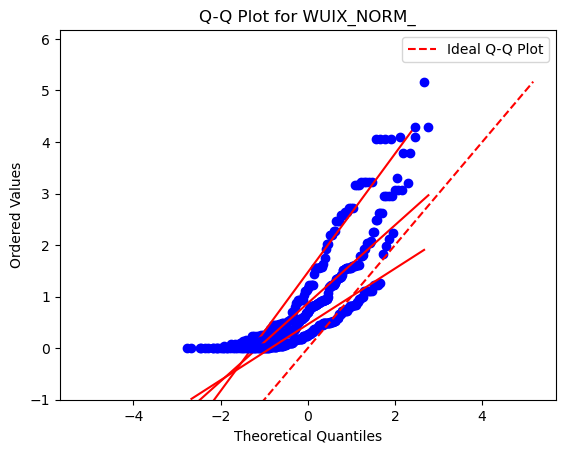

-----------------------------
  Figueira

Shapiro-Wilk Statistic: 0.617, p-value: 6.46E-20
Kolmogorov-Smirnov Statistic: 0.500, p-value: 2.28E-42
Skewness: 3.708, Kurtosis: 17.863
The data does not appear to be normally distributed.
-----------------------------
  Sarzedas de Vasco

Shapiro-Wilk Statistic: 0.906, p-value: 4.02E-06
Kolmogorov-Smirnov Statistic: 0.501, p-value: 8.88E-23
Skewness: 0.673, Kurtosis: -0.658
The data does not appear to be normally distributed.
-----------------------------
  Sarzedas de Sao Pedro

Shapiro-Wilk Statistic: 0.869, p-value: 1.33E-13
Kolmogorov-Smirnov Statistic: 0.500, p-value: 6.23E-57
Skewness: 1.404, Kurtosis: 2.317
The data does not appear to be normally distributed.
-----------------------------
  All together group

Shapiro-Wilk Statistic: 0.812, p-value: 3.48E-24
Kolmogorov-Smirnov Statistic: 0.500, p-value: 5.75E-121
Skewness: 1.693, Kurtosis: 2.864
The data does not appear to be normally distributed.


In [262]:
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import kstest
from scipy.stats import skew, kurtosis


for i in village_comp_all:

    data = concat_village[concat_village['village'] == i][type_wuix]
    
    # Create Q-Q plot for the current village and type
    stats.probplot(data, dist='norm', plot=plt)

max_value = concat_village[type_wuix].max()
min_value = concat_village[type_wuix].min()
max_data = max(abs(max_value), abs(min_value))

# Draw a straight line for comparison
x = np.linspace(-max_data, max_data)
plt.plot(x, x, color='red', linestyle='--', label='Ideal Q-Q Plot')

plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.ylim([min_value - 1, max_value + 1])
plt.title(f'Q-Q Plot for {type_wuix}')
plt.legend()

plt.show()


# Perform Shapiro-Wilk and Kolmogorov-Smirnov test, Skewness and Kurtosis individually 
for i in concat_village['village'].unique():
    data = concat_village[concat_village['village'] == i][type_wuix]
    stat, p_value = shapiro(data)
    result = kstest(data, 'norm')
    skewness = skew(data)
    kurt = kurtosis(data)

    print(f"-----------------------------\n  {i}\n")
    print(f"Shapiro-Wilk Statistic: {stat:.3f}, p-value: {p_value:.2E}")
    print(f"Kolmogorov-Smirnov Statistic: {result.statistic:.3f}, p-value: {result.pvalue:.2E}")
    print(f"Skewness: {skewness:.3f}, Kurtosis: {kurt:.3f}")

    if p_value > 0.05:
        print("The data appears to be normally distributed.")
    else:
        print("The data does not appear to be normally distributed.")

# Perform Shapiro-Wilk and Kolmogorov-Smirnov test, Skewness and Kurtosis for the joined data 
stat, p_value = shapiro(concat_village[type_wuix])
result = kstest(concat_village[type_wuix], 'norm')
skewness = skew(concat_village[type_wuix])
kurt = kurtosis(concat_village[type_wuix])

print(f"-----------------------------\n  All together group\n")
print(f"Shapiro-Wilk Statistic: {stat:.3f}, p-value: {p_value:.2E}")
print(f"Kolmogorov-Smirnov Statistic: {result.statistic:.3f}, p-value: {result.pvalue:.2E}")
print(f"Skewness: {skewness:.3f}, Kurtosis: {kurt:.3f}")

if p_value > 0.05:
    print("The data appears to be normally distributed.")
else:
    print("The data does not appear to be normally distributed.")

### Assumption of non-normally distributed 

In [263]:
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn


significance = 0.5
grouped_df = concat_village

# Grouping the data based on 'fire_affec' categories
grouped_data = [grouped_df[type_wuix][grouped_df['fire_affec'] == group] for group in grouped_df['fire_affec'].unique()] # list of WUIX
grouped_data_dict = {group: grouped_df[type_wuix][grouped_df['fire_affec'] == group].values for group in grouped_df['fire_affec'].unique()} # dict of WUIX with fire_affec

# Create a DataFrame for descriptive statistics
descriptive_df = pd.DataFrame({'Group': list(grouped_data_dict.keys()),
                               'Median': [np.median(values) for values in grouped_data_dict.values()],
                               'Size': [len(values) for values in grouped_data_dict.values()]})

# Perform Kruskal-Wallis test
stat, p_value = kruskal(*grouped_data_dict.values())

# Create a DataFrame for Kruskal-Wallis test result
kruskal_result_df = pd.DataFrame({'Statistic': [stat],
                                  'P-value': [p_value]})

# Create a DataFrame for other results
posthoc_result_df = pd.DataFrame(index=list(grouped_data_dict.keys()), columns=list(grouped_data_dict.keys()))
cohen_d_df = pd.DataFrame(index=list(grouped_data_dict.keys()), columns=list(grouped_data_dict.keys()))

for i, group1 in enumerate(descriptive_df['Group']):
    for j, group2 in enumerate(descriptive_df['Group']):
        if group1 != group2:
            # Perform post hoc Dunn's test
            if i > j:
                posthoc_results = posthoc_dunn([grouped_data_dict[group1], grouped_data_dict[group2]], p_adjust='bonferroni')
                #p_value_df.loc[group1, group2] = f'{posthoc_results.iloc[0, 1]:.3f}'
                p_value = posthoc_results.iloc[0, 1]
                posthoc_result_df.loc[group1, group2] = p_value

            # Calculate Cohen's d
            mean_diff = np.mean(grouped_data_dict[group1]) - np.mean(grouped_data_dict[group2])
            pooled_std = np.sqrt((np.std(grouped_data_dict[group1])**2 + np.std(grouped_data_dict[group2])**2) / 2)
            cohen_d = mean_diff / pooled_std
            cohen_d_df.loc[group1, group2] = cohen_d

# Display descriptive statistics
print("--------------------------\n  Descriptive Statistics:")
print(descriptive_df)

# Display Kruskal-Wallis test result
print("\n--------------------------\n  Kruskal-Wallis Test Result:")
print(kruskal_result_df)

# Display Posthoc test results
print("\n--------------------------\n  Posthoc Test Results:")
print(posthoc_result_df)

# Display Cohen's d
print("\n--------------------------\n  Cohen's d:")
print(cohen_d_df)

# Interpretation
p_value_df = posthoc_result_df.astype(float)
groups = list(grouped_data_dict.keys())
print("\n--------------------------\n  Interpretation:")
for group1 in groups:
    for group2 in groups:
        if group1 != group2 and group1 != 'NaN':
            p_value = p_value_df.loc[group1, group2]
            if p_value < significance:
                print(f"{type_wuix} in {group1} is significantly different from {group2} (p-value: {p_value}).")


--------------------------
  Descriptive Statistics:
         Group  Median  Size
0  build_affec    0.50   156
1  surro_affec    0.51   204
2     no_affec    0.56   161

--------------------------
  Kruskal-Wallis Test Result:
   Statistic   P-value
0   3.435079  0.179507

--------------------------
  Posthoc Test Results:
            build_affec surro_affec no_affec
build_affec         NaN         NaN      NaN
surro_affec    0.087331         NaN      NaN
no_affec        0.56946    0.186153      NaN

--------------------------
  Cohen's d:
            build_affec surro_affec  no_affec
build_affec         NaN    0.250062  0.081153
surro_affec   -0.250062         NaN -0.175712
no_affec      -0.081153    0.175712       NaN

--------------------------
  Interpretation:
WUIX_NORM_ in surro_affec is significantly different from build_affec (p-value: 0.08733112169768197).
WUIX_NORM_ in no_affec is significantly different from surro_affec (p-value: 0.1861528349653525).


### Assumption of normally distributed 

In [264]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Performing one-way ANOVA
anova_result = f_oneway(*grouped_data)

# Check the p-value to determine if there are significant differences
if anova_result.pvalue < 0.1:
    difference = 'significant difference'
    print("There are significant differences between groups.")
else:
    difference = 'No significant difference'
    print("There are no significant differences between groups.")

There are significant differences between groups.


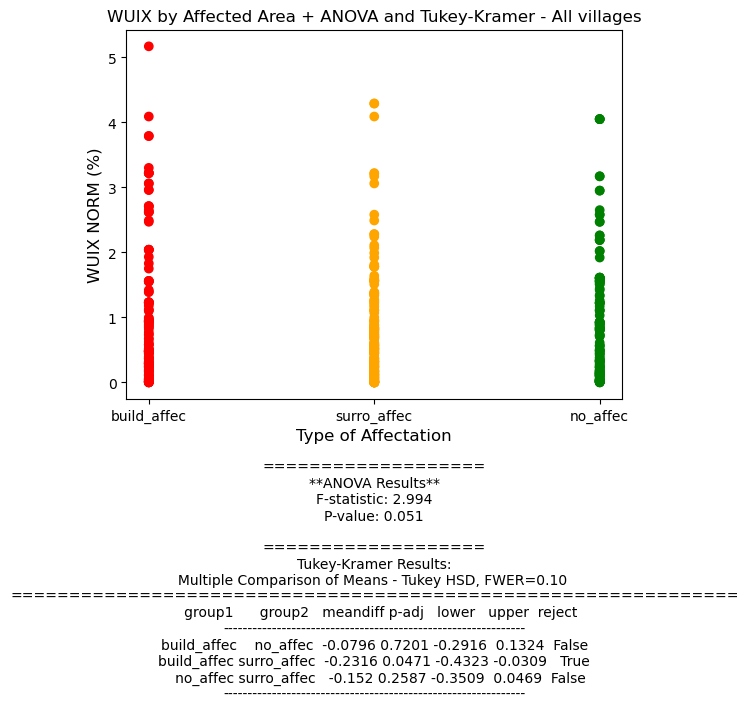

In [265]:
tukey_results = pairwise_tukeyhsd(grouped_df[type_wuix], grouped_df['fire_affec'],0.1)
colors = {'no_affec': 'green', 'surro_affec': 'orange', 'build_affec': 'red'}

plt.scatter(grouped_df['fire_affec'], grouped_df[type_wuix], c=grouped_df['fire_affec'].map(colors))

plt.xlabel('Type of Affectation', fontsize=12)
plt.ylabel('WUIX NORM (%)', fontsize=12)

# Include the ANOVA and Tukey-Kramer results in the plot
plt.text(0.5, -0.25, f"===================\n**ANOVA Results**\nF-statistic: {anova_result.statistic:.3f}\nP-value: {anova_result.pvalue:.3f}",
         ha='center', va='center', transform=plt.gca().transAxes)

tukey_title = ''
if difference == 'significant difference':
    plt.text(0.5, -0.6, f"===================\nTukey-Kramer Results:\n{tukey_results}", 
            ha='center', va='center', transform=plt.gca().transAxes)
    tukey_title = ' and Tukey-Kramer'

title = f'WUIX by Affected Area + ANOVA{tukey_title} - All villages'
plt.title(title, fontsize=12)

anova_test_path = f'{input_path}anova/'
if not os.path.exists(anova_test_path):
    os.mkdir(anova_test_path)
#plt.savefig(anova_test_path + title + f'_{village["size_Rf"]}_{village["n_number"]}.png', bbox_inches='tight')

In [266]:
tukey_results = pairwise_tukeyhsd(grouped_df[type_wuix], grouped_df['fire_affec'])
tukey_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
build_affec,no_affec,-0.0796,0.7201,-0.3218,0.1626,False
build_affec,surro_affec,-0.2316,0.0471,-0.4609,-0.0023,True
no_affec,surro_affec,-0.152,0.2587,-0.3793,0.0753,False


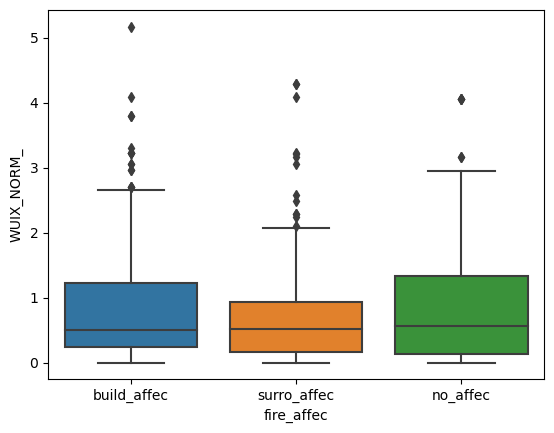

In [267]:
sns.boxplot(x='fire_affec', y=type_wuix, data=concat_village);

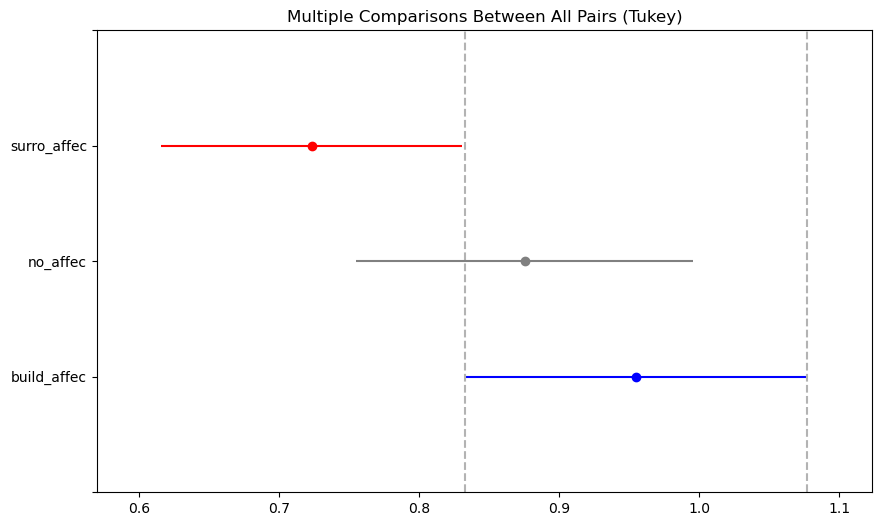

In [268]:
tukey_results.plot_simultaneous(comparison_name='build_affec');

## Correlation of real case and WUIX by N_number

In [269]:
#pd.set_option('display.max_rows', None)
n_values = []
for file in os.listdir(result_shapefile_path.rsplit('/', 1)[0]):
    if file.endswith(f'.shp'):
        n_value = file.rsplit('_', 1)[-1]
        n_value = int(n_value.rsplit('.', 1)[0])
        n_values.append(n_value)
        n_values
n_values.sort()
print(n_values)

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 80, 100]


In [270]:
paths_vill = []

for item in village_comp_all:
    path_item = f"../data/outputs/{item}/{village['year']}/resolution_{village['size_Rf']}/shape/result_intersection_{village['size_Rf']}"
    paths_vill.append(path_item)

In [271]:
def compose_gdf(divider):
    '''
    *Read the paths, organizes and merge all in the same table. Convert WUIX and Affectation and normalised*

    Args:
        divider (_Any_): 
                          *None* for dividing the values by array's max \n
                          *Value* for defining divider of values \n
                          *'no_limitation'* for using original values

    Returns:
        _GeoDataFrame_: _Complete df with all the villages and N\_numbers_
    '''
    no_affec_limit = 2
    data_rg = n_values
    #path_shp = result_shapefile_path.rsplit('_', 1)[0]
    composed_gdf = gpd.GeoDataFrame()

    for x, x_v in enumerate(paths_vill):
        for i in data_rg:
            gdf_data = gpd.read_file(f'{x_v}_{i}.shp')
            gdf_i = org_gdf_shapefile(gdf_data)
            gdf_i = gdf_i[['id','fire_affec', type_wuix]]
            gdf_i['N_value'] = i
            gdf_i['village'] = village_comp_all[x]

            fire_affec_dummies = pd.get_dummies(gdf_i['fire_affec'])
            gdf_i = pd.concat([gdf_i, fire_affec_dummies], axis=1)

            if divider == None:
                maxv = gdf_i[type_wuix].max()
                limitation = no_affec_limit 
            elif divider == 'no_limitation':
                maxv = gdf_i[type_wuix].max()
                limitation = gdf_i[type_wuix].max()
            else:
                maxv = divider
                limitation = no_affec_limit

            def calculate_wuix_affec(row):
                if row['no_affec']:
                    return float(-(1 - ((row[type_wuix]/maxv) if row[type_wuix] <= limitation else 1)))
                else:
                    return float(row[type_wuix] / gdf_i[type_wuix].max().astype('float32'))

            gdf_i['wuix_affec'] = gdf_i.apply(calculate_wuix_affec, axis=1)
            gdf_i['affec'] = gdf_i.apply(lambda row: 1 if row['build_affec'] else 1 if row['surro_affec'] else -1, axis=1)
            gdf_i = gdf_i.drop(columns=['fire_affec', 'build_affec', 'no_affec', 'surro_affec'])

            if 'WUIX_NORM' in gdf_i.columns:
                gdf_i.drop(columns=['WUIX_NORM'], inplace=True)
            composed_gdf = pd.concat([composed_gdf,gdf_i])

    composed_gdf = composed_gdf.reset_index()

    return composed_gdf

In [272]:
gdf_lim2_div_max = compose_gdf(None)
gdf_lim2_div_max

,index,id,WUIX_NORM_,N_value,village,wuix_affec,affec
0,0,1,17.110001,5,Sarzedas de Vasco,0.377038,1
1,1,2,14.620000,5,Sarzedas de Vasco,0.322168,1
2,2,3,16.510000,5,Sarzedas de Vasco,0.363817,1
3,3,4,17.350000,5,Sarzedas de Vasco,0.000000,-1
4,4,5,17.969999,5,Sarzedas de Vasco,0.000000,-1
...,...,...,...,...,...,...,...
7810,176,177,0.160000,100,Figueira,0.205128,1
7811,177,178,0.160000,100,Figueira,0.205128,1
7812,178,179,0.160000,100,Figueira,0.205128,1
7813,179,180,0.030000,100,Figueira,0.038462,1


In [273]:
gdf_lim2_div2 = compose_gdf(2)
gdf_lim2_div2

,index,id,WUIX_NORM_,N_value,village,wuix_affec,affec
0,0,1,17.110001,5,Sarzedas de Vasco,0.377038,1
1,1,2,14.620000,5,Sarzedas de Vasco,0.322168,1
2,2,3,16.510000,5,Sarzedas de Vasco,0.363817,1
3,3,4,17.350000,5,Sarzedas de Vasco,0.000000,-1
4,4,5,17.969999,5,Sarzedas de Vasco,0.000000,-1
...,...,...,...,...,...,...,...
7810,176,177,0.160000,100,Figueira,0.205128,1
7811,177,178,0.160000,100,Figueira,0.205128,1
7812,178,179,0.160000,100,Figueira,0.205128,1
7813,179,180,0.030000,100,Figueira,0.038462,1


In [274]:
gdf_unlimit = compose_gdf('no_limitation')
gdf_unlimit

,index,id,WUIX_NORM_,N_value,village,wuix_affec,affec
0,0,1,17.110001,5,Sarzedas de Vasco,0.377038,1
1,1,2,14.620000,5,Sarzedas de Vasco,0.322168,1
2,2,3,16.510000,5,Sarzedas de Vasco,0.363817,1
3,3,4,17.350000,5,Sarzedas de Vasco,-0.617673,-1
4,4,5,17.969999,5,Sarzedas de Vasco,-0.604011,-1
...,...,...,...,...,...,...,...
7810,176,177,0.160000,100,Figueira,0.205128,1
7811,177,178,0.160000,100,Figueira,0.205128,1
7812,178,179,0.160000,100,Figueira,0.205128,1
7813,179,180,0.030000,100,Figueira,0.038462,1


### Assumption of non-normally distributed 

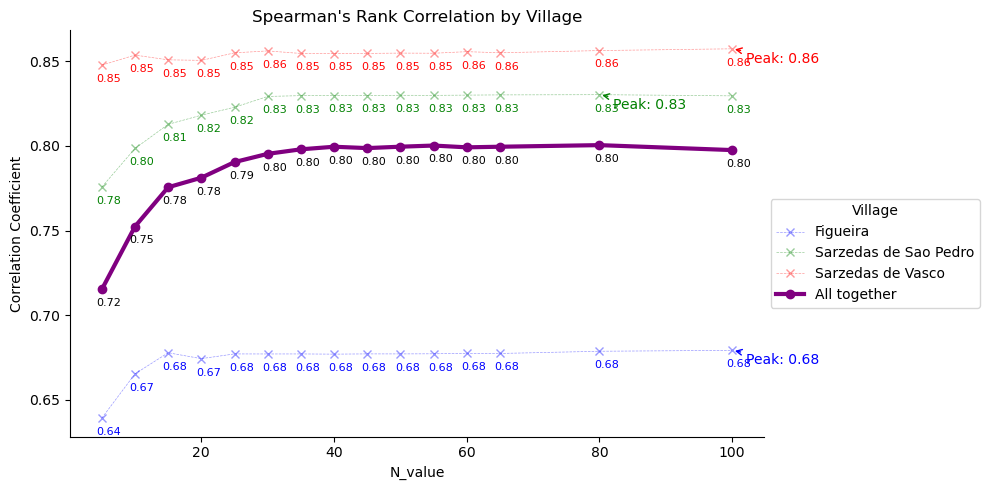

In [275]:
from scipy.stats import spearmanr


correlation_spearmanr = gdf_lim2_div_max.groupby(['N_value', 'village']).apply(lambda group: spearmanr(group['wuix_affec'], group['affec']).correlation).reset_index(name='spm_correlation')
correlation_spearmanr_all = gdf_lim2_div_max.groupby(['N_value']).apply(lambda group: spearmanr(group['wuix_affec'], group['affec']).correlation).reset_index(name='spm_correlation')

fig, ax = plt.subplots(figsize=(10,5))

# List of unique villages for coloring
village_colors = {'Figueira': 'blue', 'Sarzedas de Sao Pedro': 'green', 'Sarzedas de Vasco': 'red'}

for village, data in correlation_spearmanr.groupby('village'):
    ax.plot(data['N_value'], data['spm_correlation'], label=village, color=village_colors[village], 
            marker='x', linestyle='--', linewidth=0.5, alpha=0.4)

    # Annotate each marker with its corresponding value
    for idx, row in data.iterrows():
        ax.annotate(f'{row["spm_correlation"]:.2f}', xy=(row['N_value'], row['spm_correlation']),
                    xytext=(5, -10), textcoords='offset points', ha='center', va='center', fontsize=8,
                    color=village_colors[village])
    # Identify the peak (maximum Spearman's correlation) and annotate it
    peak_idx = data['spm_correlation'].idxmax()
    peak_value = data.loc[peak_idx, 'spm_correlation']
    ax.annotate(f'Peak: {peak_value:.2f}', xy=(data.loc[peak_idx, 'N_value'], peak_value),
                xytext=(10, -10), textcoords='offset points', color=village_colors[village],
                arrowprops=dict(arrowstyle='->', color=village_colors[village]))

# Adding a line for overall correlation
ax.plot(correlation_spearmanr_all['N_value'], correlation_spearmanr_all['spm_correlation'], 
        marker='o', label="All together", linewidth=3, color='purple')
for idx, row in correlation_spearmanr_all.iterrows():
    ax.annotate(f'{row["spm_correlation"]:.2f}', xy=(row['N_value'], row['spm_correlation']),
                xytext=(5, -10), textcoords='offset points', ha='center', va='center', fontsize=8)

ax.set_title("Spearman's Rank Correlation by Village")
ax.set_xlabel("N_value")
ax.set_ylabel("Correlation Coefficient")
ax.legend(title='Village', bbox_to_anchor=(1, 0.3), loc='lower left')
ax.spines['right'].set_color('none') 
ax.spines['top'].set_color('none')

plt.tight_layout()
plt.show()


### Assumption of normally distributed 

In [276]:
correlation_result = gdf_lim2_div_max.groupby('N_value').apply(lambda group: group['wuix_affec'].corr(group['affec']))
correlation2_result = gdf_lim2_div2.groupby('N_value').apply(lambda group: group['wuix_affec'].corr(group['affec']))
correlation3_result = gdf_unlimit.groupby('N_value').apply(lambda group: group['wuix_affec'].corr(group['affec']))

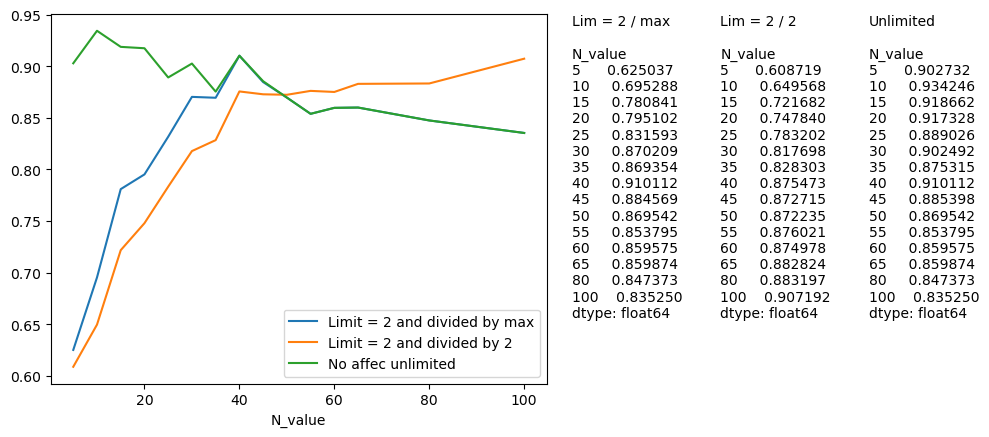

In [277]:
correlation_result.plot(label='Limit = 2 and divided by max')
correlation2_result.plot(label='Limit = 2 and divided by 2')
correlation3_result.plot(label='No affec unlimited')
plt.text(1.05, 1, f"Lim = 2 / max\n\n{correlation_result}",
         ha='left', va='top', transform=plt.gca().transAxes)
plt.text(1.35, 1, f"Lim = 2 / 2\n\n{correlation2_result}",
         ha='left', va='top', transform=plt.gca().transAxes)
plt.text(1.65, 1, f"Unlimited\n\n{correlation3_result}",
         ha='left', va='top', transform=plt.gca().transAxes)
plt.legend();